In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/petra/petr4_treinamento.csv')

In [10]:
#limpar base
base = base.dropna()


In [11]:
#vamos usar apenas nesse teste o valor de abertura (coluna 1)
#values - para o tipo numpy array
base_treino = base.iloc[:, 1:2].values

In [12]:
#aplicar normalização nos dados
#como há muitas camadas, se normalizarmos podemos acelerar o treinamento
norm = MinMaxScaler(feature_range=(0,1))
base_treino_norm = norm.fit_transform(base_treino)

In [13]:
#preparação da base para a LSTM
# 1 definir intervalo de tempo - por exemplo 4 dias ateriores
# Para prever o quinto dia, necessito dos valores de quatro dias atrás

#Vamos criar essa estrutura considerando o intervalo de 90 dias (3 meses)

previsores = []
preco_real = []
for i in range(90,1242):
  previsores.append(base_treino_norm[i-90:i,0])
  preco_real.append(base_treino_norm[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

previsores = np.reshape(previsores, (previsores.shape[0],previsores.shape[1],1))




In [14]:
print(previsores.shape[0])
print(previsores.shape[1])

1152
90


In [15]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences=True, input_shape = (previsores.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

es = EarlyStopping(monitor='loss', min_delta=1e-12, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss', save_best_only=True, verbose=1)

regressor.fit(previsores, preco_real, epochs=100, batch_size=32, callbacks=[es,rlr,mcp])

Epoch 1/100
35/36 [============================>.] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.1390
Epoch 1: loss improved from inf to 0.03462, saving model to pesos.h5
36/36 [==============================] - 9s 24ms/step - loss: 0.0346 - mean_absolute_error: 0.1391 - lr: 0.0010
Epoch 2/100
 7/36 [====>.........................] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.1014

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/36 [==========================>...] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0977
Epoch 2: loss improved from 0.03462 to 0.01599, saving model to pesos.h5
36/36 [==============================] - 1s 20ms/step - loss: 0.0160 - mean_absolute_error: 0.0992 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0919
Epoch 3: loss improved from 0.01599 to 0.01425, saving model to pesos.h5
36/36 [==============================] - 1s 16ms/step - loss: 0.0142 - mean_absolute_error: 0.0919 - lr: 0.0010
Epoch 4/100
33/36 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0831
Epoch 4: loss improved from 0.01425 to 0.01155, saving model to pesos.h5
36/36 [==============================] - 1s 15ms/step - loss: 0.0115 - mean_absolute_error: 0.0834 - lr: 0.0010
Epoch 5/100
33/36 [==========================>...] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0785
Epoch 5: loss improved from 0.011

In [17]:
#base teste

base_teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/petra/petr4_teste.csv')
preco_real_teste = base_teste.iloc[:,1:2].values
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)

entradas = base_completa[len(base_completa)-len(base_teste)-90:].values
entradas = entradas.reshape(-1,1)
entradas = norm.transform(entradas)

X_teste = []
for i in range(90,112):
  X_teste.append(entradas[i-90:i, 0])


X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0],X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = norm.inverse_transform(previsoes)




1/1 [==============================] - 3s 3s/step


In [18]:
previsoes.mean()

17.313988

In [19]:
preco_real_teste.mean()

17.87454563636364

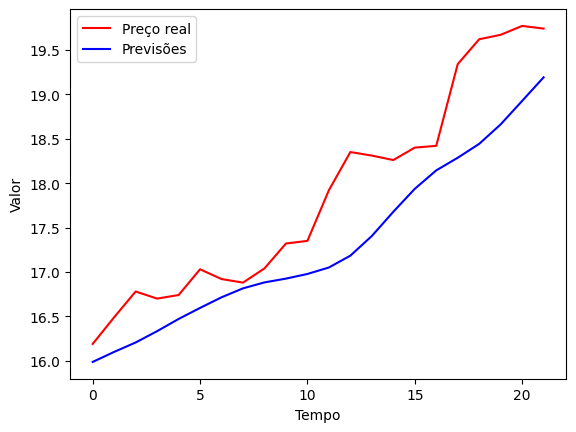

In [20]:
plt.plot(preco_real_teste, color='red', label='Preço real')
plt.plot(previsoes, color='blue', label='Previsões')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()